In [51]:
import requests
import numpy as np
import pandas as pd
import re
import pycountry
import json
import matplotlib.pyplot as plt

In [3]:
wikidata = pd.read_csv("data\wikidata25k.csv")
wikidata["genders"].unique()

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
C:\Users\brief\AppData\Local\Temp\ipykernel_20016\3610291600.py:1: SyntaxWarning: invalid escape sequence '\w'
  wikidata = pd.read_csv("data\wikidata25k.csv")


array(['female', 'male', 'trans man', 'trans woman', 'transgender',
       'intersex', 'agender', 'non-binary', 'undisclosed gender'],
      dtype=object)

C:\Users\brief\AppData\Local\Temp\ipykernel_20016\2816785850.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count = genderCount[i]
C:\Users\brief\AppData\Local\Temp\ipykernel_20016\2816785850.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pct = genderStat[i]


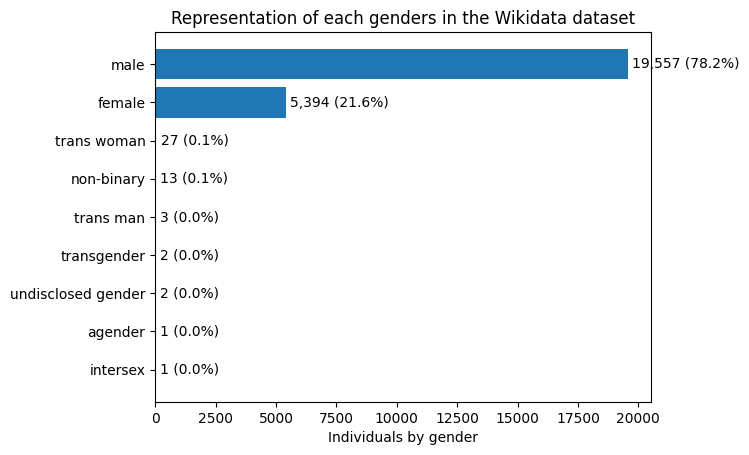

In [21]:
genderCount = wikidata["genders"].value_counts()
genderStat = (genderCount / wikidata["genders"].count()) * 100
genderLabel = genderCount.index

fig, ax = plt.subplots()
bars = ax.barh(np.arange(len(genderLabel)), genderCount)
ax.set_yticks(np.arange(len(genderLabel)), labels=genderLabel)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Individuals by gender')
ax.set_title('Representation of each genders in the Wikidata dataset')

for i, bar in enumerate(bars):
    count = genderCount[i]
    pct = genderStat[i]
    ax.text(
        bar.get_width() + max(genderCount) * 0.01,  # little offset from bar end
        bar.get_y() + bar.get_height() / 2,         # vertically centered
        f"{count:,} ({pct:.1f}%)",                  # format: "123 (45.6%)"
        va='center'
    )

plt.show()

In [ ]:
datasetMF = wikidata[(wikidata["genders"] == 'female') | (wikidata["genders"] == 'male')] # with only ~50 non-cis people in the dataset, it's easier to remove them
# MARK of a true scientist here, I'm ignoring the cool stuff and the freaks (/affectionate) 
datasetMF["dobs"] = pd.to_datetime(datasetMF["dobs"], errors="coerce")
datasetMF["birth_year"] = datasetMF["dobs"].dt.year
datasetMF.head()

C:\Users\brief\AppData\Local\Temp\ipykernel_20016\2246576719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datasetMF["dobs"] = pd.to_datetime(datasetMF["dobs"], errors="coerce")
C:\Users\brief\AppData\Local\Temp\ipykernel_20016\2246576719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datasetMF["birth_year"] = datasetMF["dobs"].dt.year


,person,person_label,genders,dobs,countries,continents,birth_year
0,http://www.wikidata.org/entity/Q10000001,Tatyana Kolotilshchikova,female,1937-04-11 00:00:00+00:00,Russia|Soviet Union,Europe|Asia,1937
1,http://www.wikidata.org/entity/Q1000002,Claus Hammel,male,1932-12-04 00:00:00+00:00,Germany,Europe,1932
2,http://www.wikidata.org/entity/Q1000006,Florian Eichinger,male,1971-07-14 00:00:00+00:00,Germany,Europe,1971
3,http://www.wikidata.org/entity/Q10000101,Eliška Hladilová,female,1993-01-23 00:00:00+00:00,Czech Republic,Europe,1993
4,http://www.wikidata.org/entity/Q100001260,Henk Rigters,male,1915-10-06 00:00:00+00:00,Kingdom of the Netherlands,Europe,1915


C:\Users\brief\AppData\Local\Temp\ipykernel_20016\730347319.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([abs(int(x)) for x in xticks])


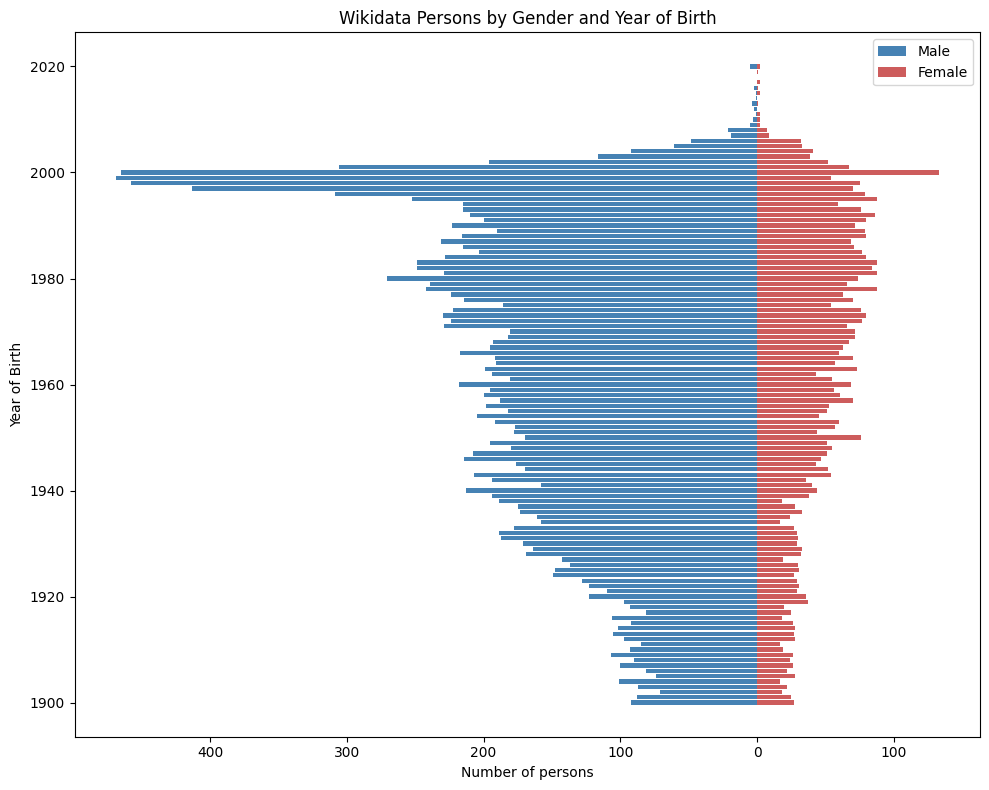

In [ ]:
counts = datasetMF.groupby(["birth_year", "genders"]).size().reset_index(name="count")
# Thanks chat, very helpful
# Pivot for male vs female counts per year
pivot = counts.pivot(index="birth_year", columns="genders", values="count").fillna(0)

# Example: if your gender column has 'male'/'female' strings
pivot = pivot.rename(columns={"male": "Male", "female": "Female"})

# Plot similar to a population pyramid
fig, ax = plt.subplots(figsize=(10, 8))

# Negative values for male (so it mirrors female side)
ax.barh(pivot.index, -pivot["Male"], color="steelblue", label="Male")
ax.barh(pivot.index, pivot["Female"], color="indianred", label="Female")

ax.set_xlabel("Number of persons")
ax.set_ylabel("Year of Birth")
ax.set_title("Wikidata Persons by Gender and Year of Birth")

# Adjust x-axis ticks to show absolute values
xticks = ax.get_xticks()
ax.set_xticklabels([abs(int(x)) for x in xticks])

ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Changing years
wikidata["dobs"] = pd.to_datetime(wikidata["dobs"], errors="coerce")
wikidata["birth_year"] = datasetMF["dobs"].dt.year

In [ ]:
# Adding ISO codes
def findISOCode(country):
    if isinstance(country, str): # in case of missing values
        try:
            return pycountry.countries.search_fuzzy(country)[0].alpha_2
        except LookupError:
            return None  # if pycountry can't find a match
    else:
        return None
    
wikidata["firstCountry"] = [re.findall('^([^|]+)', country)[0] for country in wikidata["countries"]]
wikidata["iso_country"] = wikidata["firstCountry"].apply(findISOCode)
wikidata.head(50)

,person,person_label,genders,dobs,countries,continents,iso_country,firstCountry
0,http://www.wikidata.org/entity/Q10000001,Tatyana Kolotilshchikova,female,1937-04-11T00:00:00Z,Russia|Soviet Union,Europe|Asia,RU,Russia
1,http://www.wikidata.org/entity/Q1000002,Claus Hammel,male,1932-12-04T00:00:00Z,Germany,Europe,DE,Germany
2,http://www.wikidata.org/entity/Q1000006,Florian Eichinger,male,1971-07-14T00:00:00Z,Germany,Europe,DE,Germany
3,http://www.wikidata.org/entity/Q10000101,Eliška Hladilová,female,1993-01-23T00:00:00Z,Czech Republic,Europe,CZ,Czech Republic
4,http://www.wikidata.org/entity/Q100001260,Henk Rigters,male,1915-10-06T00:00:00Z,Kingdom of the Netherlands,Europe,NL,Kingdom of the Netherlands
5,http://www.wikidata.org/entity/Q1000015,Florian Jahr,male,1983-06-23T00:00:00Z,Germany,Europe,DE,Germany
6,http://www.wikidata.org/entity/Q1000023,Wiltraut Rupp-von Brünneck,female,1912-08-07T00:00:00Z,Germany,Europe,DE,Germany
7,http://www.wikidata.org/entity/Q1000026,Gillett Griffin,male,1928-01-01T00:00:00Z,United States,North America,US,United States
8,http://www.wikidata.org/entity/Q1000044,Sylvia Bayr-Klimpfinger,female,1907-08-01T00:00:00Z,Austria,Europe,AT,Austria
9,http://www.wikidata.org/entity/Q1000045,Eugen Karl Brammertz,male,1915-04-03T00:00:00Z,Germany,Europe,DE,Germany


In [ ]:
wikidata.to_csv('data\wikidata25kFormatted.csv')